In [2]:
import matplotlib.pyplot as plt
import torchvision.transforms.v2 as tfs_v2
from torchvision.tv_tensors import Image as TVImage, Mask as TVMask
from PIL import Image
import numpy as np
from pathlib import Path
import torch.utils.data as data
import torch


In [3]:
class MassachusettsRoadsDataset(data.Dataset):
    def __init__(self, path, mode='train', patch_size=512):
        self.patch_size = patch_size
        self.mode = mode
        
        self.path_img = Path(path)
        self.path_mask = Path(path + '_labels')
        
        IMAGE_EXTS = {'.jpg', '.jpeg', '.png', '.tiff', '.tif'}
        images_dict = {p.stem: p for p in self.path_img.rglob('*') if p.suffix.lower() in IMAGE_EXTS}
        masks_dict = {p.stem: p for p in self.path_mask.rglob('*') if p.suffix.lower() in IMAGE_EXTS}
        
        all_keys = sorted(set(images_dict) & set(masks_dict))
        self.images = [images_dict[k] for k in all_keys]
        self.masks = [masks_dict[k] for k in all_keys]
        
        self.patches = self._generate_patches()
        self.length = len(self.patches)
        
        if mode == 'train':
            self.joint_transforms = tfs_v2.Compose([
                tfs_v2.RandomChoice([
                    tfs_v2.RandomRotation(degrees=[0, 0]),
                    tfs_v2.RandomRotation(degrees=[90, 90]),
                    tfs_v2.RandomRotation(degrees=[180, 180]),
                    tfs_v2.RandomRotation(degrees=[270, 270]),
                ]),

                tfs_v2.RandomAffine(
                    degrees=(-90, 90),
                    translate=(0.1, 0.1),
                    scale=(0.9, 1.1),
                    fill=0
                ),
                tfs_v2.RandomHorizontalFlip(p=0.5),
                tfs_v2.RandomVerticalFlip(p=0.5),
            ])
            
            self.color_transforms = tfs_v2.Compose([
                tfs_v2.ColorJitter(
                    brightness=0.2,
                    contrast=0.2,
                    saturation=0.2,
                    hue=0.1
                ),
            ])
        
        self.to_tensor = tfs_v2.Compose([
            tfs_v2.ToImage(),
            tfs_v2.ToDtype(torch.float32, scale=True)
        ])
        
        self.normalize = tfs_v2.Normalize(
            mean=[0.485, 0.456, 0.406], 
            std=[0.229, 0.224, 0.225]
        )
    
    def _generate_patches(self):
        patches = []
        
        for img_path, mask_path in zip(self.images, self.masks):
            width, height = 1500, 1500
            
            for y in range(0, height, self.patch_size):
                for x in range(0, width, self.patch_size):
                    if x + self.patch_size <= width and y + self.patch_size <= height:
                        patches.append({
                            'img_path': img_path,
                            'mask_path': mask_path,
                            'crop_box': (x, y, x + self.patch_size, y + self.patch_size)
                        })
        
        return patches
    
    def __getitem__(self, item):
        patch_info = self.patches[item]
        img_path = patch_info['img_path']
        mask_path = patch_info['mask_path']
        crop_box = patch_info['crop_box']
        
        img = Image.open(img_path).convert('RGB').crop(crop_box)
        mask = Image.open(mask_path).convert('L').crop(crop_box)
        
        img = TVImage(img)
        mask = TVMask(mask)
        
        if self.mode == 'train':
            img, mask = self.joint_transforms(img, mask)
            img = self.color_transforms(img)
        
        # img = self.to_tensor(img)
        # img = self.normalize(img)
        
        # mask = mask.to(torch.float32) / 255.0
        # mask = torch.where(mask >= 0.5, 1.0, 0.0)
        # mask = mask.unsqueeze(0)
        
        return img, mask
    
    def __len__(self):
        return self.length

In [4]:
dataset = MassachusettsRoadsDataset('./data_tiff/train', mode='train')

In [26]:
dataset.__len__()

4432

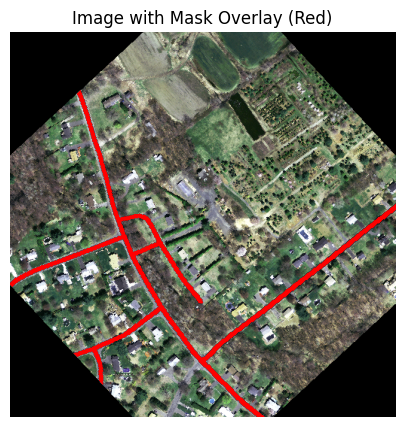

In [30]:
img, mask = dataset.__getitem__(1)

img_np = img.permute(1, 2, 0).cpu().numpy()  # [H, W, 3]
mask_np = mask.squeeze().cpu().numpy()       # [H, W]

plt.figure(figsize=(10, 5))
plt.imshow(img_np)

mask_overlay = np.zeros((*mask_np.shape, 4))
mask_overlay[mask_np > 0.5] = [1, 0, 0, 1]

plt.imshow(mask_overlay)

plt.title('Image with Mask Overlay (Red)')
plt.axis('off')
plt.show()